# Document Setup

- Project ID: EMB_ex20
- Researchers: DK
- Current Version: v2.0

See associated protocol for more details.

In [91]:
# Stdlib
import os
import sys
import random
from collections import Counter
from datetime import datetime
from IPython.display import display, Latex

# Scientific computing
## Linear algebra
import numpy as np
from scipy.sparse.linalg import eigsh
from sklearn.linear_model import LogisticRegression

## Data processing
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

## Other
from sklearn.metrics import roc_auc_score

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [92]:
metadata = {
    "PROJECT_ID": "EMB_ex20",
    "RESEARCHERS": "DK",
    "CURRENT_VERSION": "v3.0",
    "DATE": datetime.today().strftime("%Y%m%d")
}
TAG = "{PROJECT_ID}{CURRENT_VERSION}_{RESEARCHERS}_{DATE}".format(**metadata)

# Experiment

## Preface

**Goal**

Utilize logistic regression to reconstruct multiplexes from embedded remnants.

Unlike similar EMB\_ex19, ex20 utilizes LE for the embedding procedure.

**Procedure**

1. [Set-up] Let $G, H$ be the layers of a duplex.
2. [Set-up] Aggregate $G, H$; call it $A$.
3. [Set-up] Observe some partial observations from $A$; call them $\theta_G, \theta_H$.
4. [Set-up] Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$.
5. [Embedding] Embed $R_G, R_H$; call them $E_G, E_H$.
6. [Reconstruction] Select some edge, $e = (i,j) \in A$.
7. [Reconstruction] Calculate $d_G(e) = d_{E_G}(i, j), d_H(e) = d_{E_H}(i, j)$ and the quotient $d(e) = \frac{d_G(e)}{d_H(e)}$.
8. [Reconstruction] Train a logistic regression model with $\{ d(e)\}$ as predictor.
9. [Reconstruction] Predict originating layer for each edge in the test set, $A - \theta_G - \theta_H$.
10. [Analysis] Analyze reconstructive performance.

**Notes**
The core of the reconstruction from embedded layers is training a logistic model
$\begin{equation}\begin{aligned}
    R(e) &= \frac{1}{1 + e^{-\beta_1(d_G(e) / d_H(e)) - \beta_0}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1(d_G(e) / d_H(e))}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1d(e)}}\\
\end{aligned}\end{equation}$

where $d(e)$ is the quotient of $d_G(e), d_H(e)$ where $d_G(e) = d_G(i,j) = \| E_G[i] - E_G[j] \|$ for edge $e = (i,j)$ and likewise for $d_H(e)$.



## Prerequisite code

In [93]:
def generate_ring_duplex(number_of_nodes):
    """
    Generate a duplex of rings with one layer having shuffled node labels of the other.
    """
    # Create one layer, a ring network
    G = nx.cycle_graph(number_of_nodes)

    # Independent shallow copy the layer
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()

    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [94]:
def get_representation(remnant, parameters):
    # Book-keeping
    ## Indexing objects
    _nodes = sorted(remnant.nodes())  # * Force networkx indexing
    _nodes_reindexing = {node: idx for idx, node in enumerate(_nodes)}  # Allow for non-contiguous node indices

    ## Hyperparams
    dimension = np.array(parameters["dimension"])
    maxiter = len(_nodes)*parameters["maxiter_multiplier"]
    if parameters["tol_exp"] >= 0:
        tol = 0
    else:
        tol = 10**parameters["tol_exp"]
    # Calculate normalized Laplacian
    L_normalized = nx.normalized_laplacian_matrix(remnant, nodelist=_nodes)

    # Account for first eigenvalue correlated with degrees
    dimension += 1
    # Account for algebraic multiplicity of trivial eigenvalues equal to number of connected components
    num_components = nx.number_connected_components(remnant)

    dimension += num_components
    # Calculate eigenspectra
    eigenvalues, eigenvectors = eigsh(
            L_normalized, k=dimension,
            which="SM", maxiter=maxiter, tol=tol,
        )

    # * Ensure algebraic multiplcity of trivial eigenvalue matches num_components
    # TODO: Fix calculation
    # for idx, w_ in enumerate(w):
    #     trivial_ = sum([np.isclose(val, 0) for val in w_])
    #     components_ = num_components[idx]
    #     if trivial_ != components_:
    #         raise ValueError(
    #             f"""Number of components and algebraic multiplicity
    #             of trivial eigenvalue do not match in remnant layer {idx}
    #             Found {components_} components, {trivial_} near-0 eigenvalues
    #             {w_}
    #             """
    #             )
    # Retrieve eigenvectors and first non-trivial dimension-many components
    eigenvectors = np.array([
            vector[-parameters["dimension"]:]
            for vector in eigenvectors
        ])

    indexed_eigenvectors = {node: eigenvectors[idx] for idx, node in enumerate(_nodes)}

    return indexed_eigenvectors

In [95]:
def cosine_similarity(edge, vectors):
    # Retrieve nodes incident to edge
    i, j = edge

    dot_ = np.dot(vectors[i], vectors[j])
    cosine_ = dot_ / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))

    return np.arccos(cosine_)

In [96]:
def calculate_distance(edge, vectors):
    # ! >>> TMP >>>
    return cosine_similarity(edge, vectors)
    # ! <<< TMP <<<
    # # Retrieve nodes incident to edge
    # i, j = edge

    # # Calculate distance between incident nodes
    # d = np.linalg.norm(vectors[i] - vectors[j])

    # return d

In [97]:
def calculate_distance_ratio(edge, E_G, E_H):
    d_G, d_H = calculate_distance(edge, E_G), calculate_distance(edge, E_H)
    if d_H == 0 or d_G == 0:
        return 1
    else:
        return d_G / d_H

## Workflow

In [98]:
# * Experiment Parameters
# >>> LE embedding <<<
params = {
    "dimension": 40,
    "maxiter_multiplier": 100,
    "tol_exp": -8
}

# >>> Logistic regression <<<
penalty = "l2"  # L2 regularization

# >>> Other <<<
repeat = 100  # number of simulations

In [99]:
# * Steps (1) - Get desired duplex
# G, H = generate_ring_duplex(1000)
D = utils.read_file("../../data/input/raw/duplex_system=celegans.edgelist")
G, H = utils.duplex_network(D, 1, 3)

### Single run (dev)

In [100]:
# * Steps (2) thru (4) - Observe a priori information and calculate remnants
theta = 0.5
R_G, R_H, testset, trainset = utils.partial_information(G, H, theta)

In [101]:
# * Attempted regularization
A = nx.Graph()
A.add_nodes_from(R_G.nodes())
A.add_edges_from(testset.keys())

E_A = get_representation(A, params)

In [102]:
# * Step (5) - Embed remnants
E_G = get_representation(R_G, params)
E_H = get_representation(R_H, params)

In [103]:
dims_ = len(E_G[1])
N_ = int(1.1*G.number_of_nodes())
E_G_ = np.zeros((N_, dims_))
E_H_ = np.zeros((N_, dims_))
E_A_ = np.zeros((N_, dims_))
for node, vector in E_G.items():
    E_G_[node,:] = vector

for node, vector in E_H.items():
    E_H_[node,:] = vector

for node, vector in E_A.items():
    E_A_[node,:] = vector

E_G = E_G_
E_H = E_H_
E_A = E_A_

In [104]:
scaler = StandardScaler()

In [105]:
E_G = scaler.fit_transform(E_G)
E_H = scaler.fit_transform(E_H)
E_A = scaler.fit_transform(E_A)

In [106]:
train_d_A = []
train_d_G = []
train_d_H = []
train_labels = []
test_d_A = []
test_d_G = []
test_d_H = []
test_labels = []

for edge, gt in trainset.items():
    d_G = calculate_distance(edge, E_G)
    d_H = calculate_distance(edge, E_H)
    d_A = calculate_distance(edge, E_A)

    train_d_A.append(d_A)
    train_d_G.append(d_G)
    train_d_H.append(d_H)
    train_labels.append(gt)

for edge, gt in testset.items():
    d_G = calculate_distance(edge, E_G)
    d_H = calculate_distance(edge, E_H)
    d_A = calculate_distance(edge, E_A)

    test_d_A.append(d_A)
    test_d_G.append(d_G)
    test_d_H.append(d_H)
    test_labels.append(gt)

train_d_A = np.array(train_d_A)
train_d_G = np.array(train_d_G)
train_d_H = np.array(train_d_H)
test_d_A = np.array(test_d_A)
test_d_G = np.array(test_d_G)
test_d_H = np.array(test_d_H)

In [107]:
X_train = np.asarray([train_d_G, train_d_H]).transpose()
X_test = np.asarray([test_d_G, test_d_H]).transpose()

In [108]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_test_reduced = pca.transform(X_test)

In [109]:
cs_ = ["purple", "orange"]
c_ = [cs_[idx] for idx in test_labels]

Text(0.5, 1.0, "PCA reduction of test set's remnant distances")

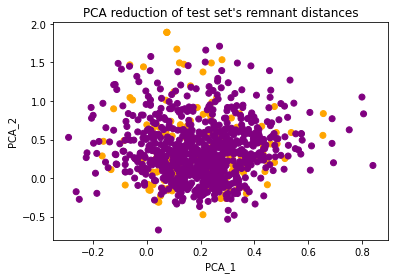

In [110]:
plt.figure()

plt.scatter(X_test_reduced[:,0], X_test_reduced[:,1], c=c_)

plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.title("PCA reduction of test set's remnant distances")

In [112]:
A_ = PCA(n_components=2).fit(np.asarray([train_d_G / train_d_A, train_d_H / train_d_A]).transpose())
A_ = A_.transform(np.asarray([test_d_G / test_d_A, test_d_H / test_d_A]).transpose())
#  A_ = PCA(n_components=2).fit_transform(np.asarray([test_d_G / test_d_A, test_d_H / test_d_A]).transpose())
c_ = [cs_[idx] for idx in test_labels]

A_ = scaler.fit_transform(A_)

plt.scatter(A_[:,0], A_[:,1], c=c_)

plt.hlines(np.median(A_[:,1]), min(A_[:,0]), max(A_[:,0]), color="red", linestyle="--", label="Y Median")
plt.hlines(np.mean(A_[:,1]), min(A_[:,0]), max(A_[:,0]), color="red", linestyle="-.", label="Y Mean")
plt.vlines(np.median(A_[:,0]), min(A_[:,1]), max(A_[:,1]), color="black", linestyle="--", label="X Mean")
plt.vlines(np.mean(A_[:,0]), min(A_[:,1]), max(A_[:,1]), color="black", linestyle="-.", label="X Mean")

plt.legend()

plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.title("PCA reduction of aggregate-normalized test set's remnant distances")

/tmp/ipykernel_22023/2254678600.py:2: RuntimeWarning: invalid value encountered in true_divide
  A_ = A_.transform(np.asarray([test_d_G / test_d_A, test_d_H / test_d_A]).transpose())
/tmp/ipykernel_22023/2254678600.py:2: RuntimeWarning: divide by zero encountered in true_divide
  A_ = A_.transform(np.asarray([test_d_G / test_d_A, test_d_H / test_d_A]).transpose())


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
class_ = 0
P_below = 0
P_above = 0
for idx, y in enumerate(A_[:,1]):
    if test_labels[idx] == class_:
        if y <= np.mean(A_[:,1]):
            P_below += 1
        else:
            P_above += 1

print("="*12)
print(f"Class: {cs_[class_]}")
print(f"Number above: {P_above}, Number below: {P_below}, (1 - ) Accuracy: {P_below / (P_above + P_below):.4f}")
print("="*12)

IndexError: list index out of range

In [113]:
# * Steps (6) and (7) - Calculate distances of nodes incident to edges in both embeddings
distance_ratios_train = np.array([
    np.log(calculate_distance_ratio(edge, E_G, E_H)) # / np.log(calculate_distance(edge, E_A))
    for edge in trainset
]).reshape(-1, 1)
distance_ratios_test = np.array([
    np.log(calculate_distance_ratio(edge, E_G, E_H)) # / np.log(calculate_distance(edge, E_A))
    for edge in testset
]).reshape(-1, 1)

labels_train = list(trainset.values())
labels_test = list(testset.values())

Text(0.5, 1.0, 'Training set distances')

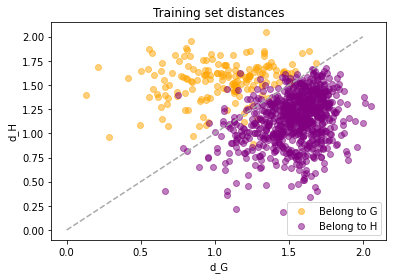

In [114]:
plt.figure()

pts0 = [(calculate_distance(edge, E_G), calculate_distance(edge, E_H)) for edge, class_ in trainset.items() if class_ == 0]
pts1 = [(calculate_distance(edge, E_G), calculate_distance(edge, E_H)) for edge, class_ in trainset.items() if class_ == 1]
plt.scatter([pt[0] for pt in pts1], [pt[1] for pt in pts1], label="Belong to G", color="orange", alpha=0.5)
plt.scatter([pt[0] for pt in pts0], [pt[1] for pt in pts0], label="Belong to H", color="purple", alpha=0.5)

xmax = max(max([p[0] for p in pts0]), max([p[1] for p in pts0]))
xrange = np.arange(0, xmax)
plt.plot(xrange, xrange, linestyle="--", color="darkgray")


plt.legend()

plt.xlabel("d_G")
plt.ylabel("d_H")
plt.title("Training set distances")

Text(0.5, 1.0, 'Test set distances')

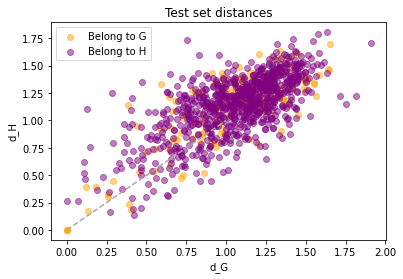

In [115]:
plt.figure()

pts0 = [(calculate_distance(edge, E_G), calculate_distance(edge, E_H)) for edge, class_ in testset.items() if class_ == 0]
pts1 = [(calculate_distance(edge, E_G), calculate_distance(edge, E_H)) for edge, class_ in testset.items() if class_ == 1]
plt.scatter([pt[0] for pt in pts1], [pt[1] for pt in pts1], label="Belong to G", color="orange", alpha=0.5)
plt.scatter([pt[0] for pt in pts0], [pt[1] for pt in pts0], label="Belong to H", color="purple", alpha=0.5)

xmax = max(max([p[0] for p in pts0]), max([p[1] for p in pts0]))
xrange = np.arange(0, xmax)
plt.plot(xrange, xrange, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("d_G")
plt.ylabel("d_H")
plt.title("Test set distances")

Text(0.5, 1.0, 'Layer origination as a function of distance quotient')

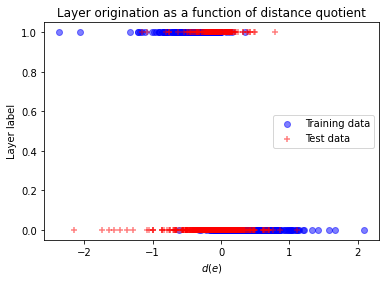

In [116]:
plt.figure()

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.legend()

plt.xlabel("$d(e)$")
plt.ylabel("Layer label")
plt.title("Layer origination as a function of distance quotient")

In [117]:
# * Step (8) - Train a logistic regression
model = LogisticRegression(random_state=37, max_iter=10**4)
model.fit(distance_ratios_train, labels_train)

coef = model.coef_
intercept = model.intercept_

Text(0.5, 1.0, 'Layer origination as a function of distance quotient')

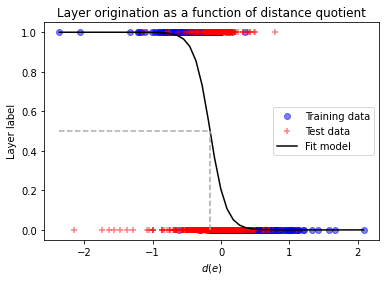

In [118]:
plt.figure()

expit = lambda x: 1 / (1 + np.exp(-x*coef[0] - intercept[0]))
xmin = min(min(distance_ratios_train), min(distance_ratios_test))
xmax = max(max(distance_ratios_train), max(distance_ratios_test))
xrange = np.linspace(xmin, xmax)

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.plot(xrange, [expit(x) for x in xrange], label="Fit model", color="black")

model_inv_threshold = -intercept[0]/coef[0]
plt.vlines(model_inv_threshold, 0, 0.5, linestyle="--", color="darkgray")
plt.hlines(0.5, xmin, model_inv_threshold, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("$d(e)$")
plt.ylabel("Layer label")
plt.title("Layer origination as a function of distance quotient")

In [119]:
# * Step (9) - Predict testset with reconstruction
print(f"Model score: {model.score(distance_ratios_test, labels_test):.4f}")

Model score: 0.6158


In [120]:
model.score(distance_ratios_train, labels_train)

0.9566596194503171